# The Basic Steps of Online Monitoring

## 1 Real-time Data Server

In [2]:
import redis
r = redis.Redis(host='localhost')
r.set('foo', 'bar')
r.get('foo')

b'bar'

## 2 Real-time Data Services with Python




### 2.2 Real-time Data Service

<ol>
<li>setup Tag in  Data Service
<li>Send data to Data Service
<li>Get data from Data Service and analyze
</ol>

#### 2.2.1 setup Tag in Data Service

In [25]:
# -*- coding: utf-8 -*-
import redis

conn = redis.Redis('localhost')

def TagDefToRedisHashKey(tagdeflist):
    pipe = conn.pipeline()
    for element in tagdeflist:
        pipe.hmset(
            element['id'], {'desc': element['desc'], 'value': "-10000", 'ts': ""})
    pipe.execute()

def TagDefFromRedisHash(tagdeflist):
    taglist = []
    for element in tagdeflist:
        htag = conn.hgetall(element['id'])
        taglist.append(htag)
    return taglist


In [26]:
unittagdeflist=[]
unittagdeflist.append({'id':"CSDC.DCS2AI.2JZA2226",'desc':"二号机组高压缸入口压力"})
unittagdeflist.append({'id':"CSDC.DCS2AI.2JZA2408",'desc':"二号机组高压缸入口温度"})
unittagdeflist.append({'id':"CSDC.DCS2AI.2JZA2230",'desc':"二号机组高压缸出口压力"})
unittagdeflist.append({'id':"CSDC.DCS2AI.2JZA2459",'desc':"二号机组高压缸出口温度"})
unittagdeflist.append({'id':"CSDC.DCS2AI.2JZA2264",'desc':"大气压力"})

TagDefToRedisHashKey(unittagdeflist)

taglist=TagDefFromRedisHash(unittagdeflist)
print(taglist[0])

{b'ts': b'', b'value': b'-10000', b'desc': b'\xe4\xba\x8c\xe5\x8f\xb7\xe6\x9c\xba\xe7\xbb\x84\xe9\xab\x98\xe5\x8e\x8b\xe7\xbc\xb8\xe5\x85\xa5\xe5\x8f\xa3\xe5\x8e\x8b\xe5\x8a\x9b'}


### 2.2.2 Send Data to Redis



In [27]:
# -*- coding: utf-8 -*-
from datetime import *

def SendToRedisHash(tagvaluelist):
    pipe = conn.pipeline()

    curtime = datetime.now()

    for element in tagvaluelist:
        pipe.hmset(element['id'], {'value': element['value'], 'ts': curtime})
    pipe.execute()


In [28]:
unittagvaluelist=[]
unittagvaluelist.append({'id':"CSDC.DCS2AI.2JZA1030",'value':16.38525})
unittagvaluelist.append({'id':"CSDC.DCS2AI.2JZA2408",'value':538.37})
unittagvaluelist.append({'id':"CSDC.DCS2AI.2JZA2230",'value':3.035039})
unittagvaluelist.append({'id':"CSDC.DCS2AI.2JZA2459",'value':313.2931})
unittagvaluelist.append({'id':"CSDC.DCS2AI.2JZA2264",'value':100.5281})
SendToRedisHash(unittagvaluelist)

print(unittagvaluelist[0])
print(conn.hmget(unittagvaluelist[0]['id'], 'value', 'ts'))
 

{'value': 16.38525, 'id': 'CSDC.DCS2AI.2JZA1030'}
[b'16.38525', b'2015-12-03 21:41:17.984464']


### 2.2.3 Get Real-time Data from Redis

In [29]:
# -*- coding: utf-8 -*-
def tagvalue_redis(taglist):
        #        for i in range(self.tagcount):
        #            self.taglist[i]['value']= conn.hget(self.taglist[i]['name'],'value').decode()
        tagcount=len(taglist)
        pipe = conn.pipeline()
        for i in range(tagcount):
            pipe.hmget(taglist[i]['id'], 'value', 'ts')
        tagvaluelist = pipe.execute()

        for i in range(tagcount):
            taglist[i]['value'] = tagvaluelist[i][0].decode()
            taglist[i]['ts'] = tagvaluelist[i][1].decode()


In [32]:
unittaglist=[]
unittaglist.append({'id':"CSDC.DCS2AI.2JZA1030"})
unittaglist.append({'id':"CSDC.DCS2AI.2JZA2408"})
unittaglist.append({'id':"CSDC.DCS2AI.2JZA2230"})
unittaglist.append({'id':"CSDC.DCS2AI.2JZA2459"})
unittaglist.append({'id':"CSDC.DCS2AI.2JZA2264"})

tagvalue_redis(unittaglist)

print(unittaglist[0])
        

{'ts': '2015-12-03 21:41:17.984464', 'value': '16.38525', 'id': 'CSDC.DCS2AI.2JZA1030'}


### 2.2.4  Online moitoring internal efficiency of turbine

In [33]:
# -*- coding: utf-8 -*-
from seuif97 import *

def CylinderEff(cylinder):
    """simple function  for cylinde using 'dict' """

    cylinder['inlet']['h'] = pt2h(cylinder['inlet']['p'], cylinder['inlet']['t'])
    cylinder['inlet']['s'] = pt2s(cylinder['inlet']['p'], cylinder['inlet']['t'])

    cylinder['outlet']['h'] = pt2h(cylinder['outlet']['p'], cylinder['outlet']['t'])
    cylinder['outlet']['s'] = pt2s(cylinder['outlet']['p'], cylinder['outlet']['t'])

    # h2s is the specific enthalpy at state 2 for the isentropic turbine
    h2s = ps2h(cylinder['outlet']['p'], cylinder['inlet']['s'])
    
    cylinder['h2s'] = h2s
     
    hds = cylinder['inlet']['h'] - h2s  # isentropic specific enthalpy drop
    hd = cylinder['inlet']['h'] - cylinder['outlet']['h']  # specific enthalpy drop

    cylinder['eff'] = 100 * hd / hds

    return cylinder


In [34]:
hp = {'inlet':{}, 'outlet':{}, 'h2s':None,'eff':None}

minlet = {'p':None, 't': None, 'h': None, 's':None}
moutlet = {'p': None, 't': None, 'h': None, 's': None}

pam=float(unittaglist[4]['value'])/1000

minlet['p']=float(unittaglist[0]['value'])+pam
minlet['t']=float(unittaglist[1]['value'])
moutlet['p']=float(unittaglist[2]['value'])+pam
moutlet['t']=float(unittaglist[3]['value'])

hp['inlet'] = dict(minlet)
hp['outlet'] = dict(moutlet)
hp = CylinderEff(hp)

print('The internal efficiency =', hp['eff'], '%')

The internal efficiency = 81.71506348039361 %


In [35]:
# -*- coding: utf-8 -*-
"""
    visualize steam expansion line in cylinder
"""

import matplotlib.pyplot as plt
import numpy as np
from seuif97 import *

def CylinderPlot(cylinder):
    # 4条线：p1、p2 等压，等熵焓降线、膨胀线

    p1 = cylinder['inlet']['p']
    t1 = cylinder['inlet']['t']
    s1 = cylinder['inlet']['s']
    h1 = cylinder['inlet']['h']
    
    p2 = cylinder['outlet']['p']
    t2 = cylinder['outlet']['t']
    s2 = cylinder['outlet']['s']
    h2 = cylinder['outlet']['h']
    
    eff = cylinder['eff']
    
    hs = cylinder['h2s']
    
    samp = 0.01
     
    smp1 = s1 - samp
    hsmp1 = ps2h(p1, smp1)
    sap1 = s1 + samp
    hsap1 = ps2h(p1, sap1)

    smt1 = s1 - samp
    hsmt1 = ps2h(p1, smp1)
    sat1 = s1 + samp
    hsat1 = ts2h(t1, sap1)
    
    # 1 p1等压
    point_p1_h = np.zeros(shape=3)
    point_p1_h[0] = hsmp1
    point_p1_h[1] = h1
    point_p1_h[2] = hsap1
    point_p1_s = np.zeros(shape=3)
    point_p1_s[0] = smp1
    point_p1_s[1] = s1
    point_p1_s[2] = sap1

    # 2 p2 等压
    smp2 = s1 - samp  # 等熵焓降点延伸
    hsmp2 = ps2h(p2, smp2)
    sap2 = s2 + samp
    hsap2 = ps2h(p2, sap2)

    smt2 = s2 - samp
    hsmt2 = ps2h(p1, smp1)
    sat2 = s2 + samp
    hsat2 = ts2h(t2, sap1)

    point_p2_h = np.zeros(shape=3)
    point_p2_h[0] = hsmp2
    point_p2_h[1] = h2
    point_p2_h[2] = hsap2

    point_p2_s = np.zeros(shape=3)
    point_p2_s[0] = smp2
    point_p2_s[1] = s2
    point_p2_s[2] = sap2

    # 3 等熵焓降
    point_is_h = np.zeros(shape=2)
    point_is_h[0] = h1
    point_is_h[1] = hs
    point_is_s = np.zeros(shape=2)
    point_is_s[0] = s1
    point_is_s[1] = s1

    # 4 HP Expansion Line
    point_hp_h = np.zeros(shape=2)
    point_hp_h[0] = h1
    point_hp_h[1] = h2
    point_hp_s = np.zeros(shape=2)
    point_hp_s[0] = s1
    point_hp_s[1] = s2

    plt.plot(point_p1_s, point_p1_h, 'bs-', label='iP')

    plt.plot(point_p2_s, point_p2_h, 'bs-', label=r'$\frac{1}{2}\pi$')
    plt.plot(point_is_s, point_is_h, 'rs-', label='is')
    plt.plot(point_hp_s, point_hp_h, 'rs-', label='HP Expansion Line"')
    plt.minorticks_on()
    
    _title = 'The isentropic efficiency = ' + \
    r'$\frac{h1-h2}{h1-h2s}$' + '=' + '{:.2f}'.format(eff) + '%'
    plt.legend(loc="center left", bbox_to_anchor=[0.5, 0.5],
           ncol=2, shadow=True, title=_title)

    # annotate some interesting points using the annotate command
    plt.annotate('(P1,T1)',
             xy=(s1, h1), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate('(P2,T2)',
             xy=(s2, h2), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.xlabel('s(kJ/(kg.K))')
    plt.ylabel('h(kJ/kg)')
    plt.show()

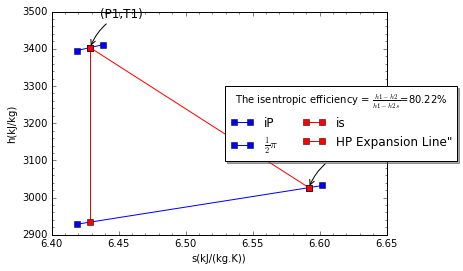

In [20]:
# -*- coding: utf-8 -*-
%matplotlib inline

hp = {'inlet':{}, 'outlet':{}, 'eff':None}

minlet['p']=float(unittaglist[0]['value'])
minlet['t']=float(unittaglist[1]['value'])
moutlet['p']=float(unittaglist[2]['value'])
moutlet['t']=float(unittaglist[3]['value'])

hp['inlet'] = dict(minlet)
hp['outlet'] = dict(moutlet)

hp = CylinderEff(hp)
CylinderPlot(hp)

## Reference

<ol>
<li>The Redis Documentation. http://redis.io/documentation
<li>JOSIAH L. CARLSON. Redis in Action. Manning Publications Co. 2013 
</ol>